In [1]:
%matplotlib inline

In [2]:
import os
import torch

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.model_selection import train_test_split

from data_generator import DataGen

In [3]:
class Autoencoder(nn.Module):

    def __init__(self, num_channel):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channel, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv1_tr = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=1)

        self.conv2 = nn.Conv2d(16, 8, 3, stride=2, padding=1)
        self.conv2_tr = nn.ConvTranspose2d(8, 16, 3, stride=2)

        self.conv3 = nn.Conv2d(8, 8, 3, stride=2, padding=1)
        self.conv3_tr = nn.ConvTranspose2d(8, 8, 3, stride=2)

        self.conv4 = nn.Conv2d(8, 8, 2, stride=2, padding=1)
        self.conv4_tr = nn.ConvTranspose2d(8, 8, 2, stride=2, padding=1)

        self.fc1 = nn.Linear(8*7*7, 128)
        self.fc1_tr = nn.Linear(128, 8*7*7)

        self.fc2 = nn.Linear(128, 3)
        self.fc2_tr = nn.Linear(3, 128)

    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 8 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def decoder(self, x):
        x = F.relu(self.fc2_tr(x))
        x = F.relu(self.fc1_tr(x))
        x = x.view(-1, 8, 7, 7)
        x = F.relu(self.conv4_tr(x))
        x = F.relu(self.conv3_tr(x))
        x = F.relu(self.conv2_tr(x))
        x = F.sigmoid(self.conv1_tr(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
def get_model(num_channel):
    net = Autoencoder(num_channel=num_channel)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    return net, optimizer

In [5]:
def fit(net, optimizer, train_dl, test_dl, epochs=5):
    loss_function = nn.BCELoss()
    for epoch in range(epochs):
        net.train()
        for x, y in train_dl:
            pred = net(x)
            loss = loss_function(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        net.eval()
        with torch.no_grad():
            test_loss = sum(loss_function(net(x), y) for x, y in test_dl)
        print('epoch: {}/{} - train_loss: {:.4f} - test_loss: {:.4f}'.format(epoch + 1, epochs, loss, test_loss / len(test_dl)))

In [6]:
def to_tensor(x):
    return torch.from_numpy(x).float()


def get_data(height, width, num_channel, path, size, bs):
    dgen = DataGen(height, width, num_channel)
    x, y = dgen.get_data(path, False, size, True)
    print('Data loaded...\nx:{}\ty:{}\n'.format(x.shape, y.shape))

    x = x / 255.
    y = y / 255.

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True)
    x_train, x_test, y_train, y_test = map(to_tensor, (x_train, x_test, y_train, y_test))

    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    test_ds = TensorDataset(x_test, y_test)
    test_dl = DataLoader(test_ds, batch_size=bs)
    return train_dl, test_dl

In [7]:
DATA_DIR = './data/data_simple_movement/cartesian/'
HEIGHT = 100
WIDTH = 100
NUM_CHANNEL = 2

In [8]:
net, optimizer = get_model(num_channel=2)

train_dl, test_dl = get_data(
    height=HEIGHT,
    width=WIDTH,
    num_channel=NUM_CHANNEL,
    path=DATA_DIR,
    size=8,
    bs=10
)

fit(net, optimizer, train_dl, test_dl, epochs=100)

Data loaded...
x:(96, 2, 100, 100)	y:(96, 1, 100, 100)



C:\Users\ttanj\Miniconda3\envs\dl\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 1/100 - train_loss: 0.5924 - test_loss: 0.5910
epoch: 2/100 - train_loss: 0.5778 - test_loss: 0.5761
epoch: 3/100 - train_loss: 0.5517 - test_loss: 0.5451
epoch: 4/100 - train_loss: 0.3772 - test_loss: 0.3403
epoch: 5/100 - train_loss: 0.2559 - test_loss: 0.2447
epoch: 6/100 - train_loss: 0.1766 - test_loss: 0.1759
epoch: 7/100 - train_loss: 0.1437 - test_loss: 0.1434
epoch: 8/100 - train_loss: 0.1261 - test_loss: 0.1258
epoch: 9/100 - train_loss: 0.1144 - test_loss: 0.1138
epoch: 10/100 - train_loss: 0.1017 - test_loss: 0.1018
epoch: 11/100 - train_loss: 0.0912 - test_loss: 0.0907
epoch: 12/100 - train_loss: 0.0807 - test_loss: 0.0802
epoch: 13/100 - train_loss: 0.0722 - test_loss: 0.0720
epoch: 14/100 - train_loss: 0.0665 - test_loss: 0.0659
epoch: 15/100 - train_loss: 0.0607 - test_loss: 0.0611
epoch: 16/100 - train_loss: 0.0574 - test_loss: 0.0570
epoch: 17/100 - train_loss: 0.0543 - test_loss: 0.0534
epoch: 18/100 - train_loss: 0.0498 - test_loss: 0.0503
epoch: 19/100 - tra

In [11]:
for x, y in test_dl:
    x_test, y_test = x, y

decoded_imgs = net(x_test).detach().numpy().transpose(0, 2, 3, 1)  # Channel as last dimension
x_test = x_test.detach().numpy().transpose(0, 2, 3, 1)
y_test = y_test.detach().numpy().transpose(0, 2, 3, 1)

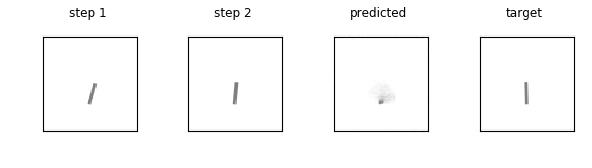

In [14]:
idx = 2  # change index for differnet test image

fig, axes = plt.subplots(figsize=((10, 3)), nrows=1, ncols=NUM_CHANNEL+2)

# display input images
for i, ax in enumerate(axes.flat[:NUM_CHANNEL]):
    ax.imshow(x_test[idx][:, :, i].reshape(HEIGHT, WIDTH), cmap='gray')
    ax.axis('off'), ax.set_title('step ' + str(i+1))
    
# display prediction
axes[NUM_CHANNEL].imshow(decoded_imgs[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
axes[NUM_CHANNEL].axis('off'), axes[NUM_CHANNEL].set_title('predicted')

# display target
axes[NUM_CHANNEL+1].imshow(y_test[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
axes[NUM_CHANNEL+1].axis('off'), axes[NUM_CHANNEL+1].set_title('target')

plt.show()